# COSMOLOGY CALCULATOR

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import astropy.constants as cons
import astropy.units as u
from astropy.cosmology import Planck18
import os 

### Set the constant

In [3]:
# Define constants
H_0 = Planck18.H0  # Hubble constant in (km/s)/Mpc
H0_conv = H_0.to(u.Gyr**-1)  # Convert H0 to Gyr^-1
H0 = 0.0691967050869917  # H0 value in Gyr^-1 (without unit)

# Flat universe assumption (k = 0)
k = 0  # Curvature parameter for flat universe
a0 = 1.0  # Scale factor today

# Time values
tau0 = 1e-10  # Lookback time today (near zero)

# Speed of light in Mpc/Gyr
c_conv = cons.c.to(u.Mpc/u.Gyr)  # c in Mpc/Gyr
c = 306.6013937855506  # Speed of light value (without unit)

# Constant used in distance calculations
constant = c / H0  # c/H0 in Mpc

## Define function

### Friedmann equation: `dadtau`

Calculates the rate of change of the scale factor \( a \) with respect to proper time \( $\tau$ \).

### Hubble parameter: `H`

Calculates the Hubble parameter \( H(z) \) at a given scale factor.


In [4]:
# Define the differential equation da/dτ
def dadtau(a, H0, Omega_m, Omega_Lambda):
    return -H0 * np.sqrt((Omega_m / a) + (a**2 * Omega_Lambda) + (1 - Omega_m - Omega_Lambda))

# Calculate Hubble parameter H(z)
def H(a, H0, Omega_m, Omega_Lambda):
    return (-1/a) * dadtau(a, H0, Omega_m, Omega_Lambda)

### Cosmological Calculator Function: `cosmocal`

The `cosmocal` function computes the evolution of several cosmological parameters, including the scale factor (`a`), redshift (`z`), the Hubble parameter (`H`), and comoving distances, for different cosmological models. This function allows for the exploration of various combinations of matter density (`Ω_m`) and dark energy density (`Ω_Λ`), with results compared against known analytical solutions for specific cases.

#### Function Parameters:
- **`Omega_m`**: The matter density parameter.
- **`Omega_Lambda`**: The dark energy density parameter (cosmological constant).
- **`dtau`**: The time step for the numerical integration (proper time increment).

#### Cosmological Models:
1. **Matter-only universe (`Ω_m = 1, Ω_Λ = 0`)**: The evolution of a universe dominated entirely by matter.
2. **Empty universe (`Ω_m = 0, Ω_Λ = 0`)**: A universe without matter or dark energy.
3. **Lambda-only universe (`Ω_m = 0, Ω_Λ = 1`)**: A universe dominated entirely by dark energy.

#### Numerical and Analytical Calculations:
For each case, the function calculates:
- The scale factor `a` (both analytical and numerical values).
- The Hubble parameter `H` (both analytical and numerical values).
- The comoving distance `D_p`, angular diameter distance `D_A`, and luminosity distance `D_L`.

The function uses **Euler's method** to perform the numerical integration of the scale factor, based on the density parameters provided, and iteratively computes the corresponding cosmological quantities.

#### Outputs:
The function returns an object that contains:
- **Interpolated comoving distance** as a function of redshift.
- **Numerical values** for scale factor (`a`), redshift (`z`), Hubble parameter (`H`), and distances (`D_A`, `D_L`).
- **Analytical values** for comparison where applicable.

In [5]:
def cosmocal(Omega_m, Omega_Lambda, dtau):
    # Matter-only universe
    if (Omega_m == 1.0) & (Omega_Lambda == 0.0):
        t0 = 2 / (3 * H0)
        tau_values = np.arange(tau0, t0, dtau)
        a_analytic = (1 - (tau_values / t0)) ** (2 / 3)
        H_analytic = H(a_analytic, H0, Omega_m, Omega_Lambda)
        Dp_analytic = 2 * (c / H0) * (1 - a_analytic ** 0.5)
    
    # Empty universe
    elif (Omega_m == 0.0) & (Omega_Lambda == 0.0):
        t0 = 1 / H0
        tau_values = np.arange(tau0, t0, dtau)
        a_analytic = 1 - (tau_values / t0)
        H_analytic = H(a_analytic, H0, Omega_m, Omega_Lambda)
        Dp_analytic = (c / H0) * np.log(1 / a_analytic)
    
    # Lambda-only universe
    elif (Omega_m == 0.0) & (Omega_Lambda == 1.0):
        t0 = 13.7
        tau_values = np.arange(tau0, t0, dtau)
        a_analytic = np.exp(-H0 * tau_values)
        H_analytic = H(a_analytic, H0, Omega_m, Omega_Lambda)
        Dp_analytic = constant * (1 / a_analytic - 1)
    
    # General case
    else:
        t0 = 13.8
        tau_values = np.arange(tau0, t0, dtau)
        a_analytic, H_analytic, Dp_analytic = 1, 1, 1

    # Calculate z, DA, DL
    z_analytic = (1 / a_analytic) - 1
    DA_analytic = Dp_analytic * a_analytic
    DL_analytic = Dp_analytic / a_analytic

    # Initialize arrays for numerical calculation
    a_values = np.zeros_like(tau_values)
    redshift_values = np.zeros_like(tau_values)
    comoving_distance = np.zeros_like(tau_values)
    H_values = np.zeros_like(tau_values)
    a_values[0] = a0

    # Numerical integration (Euler's method)
    for i in range(1, len(tau_values)):
        dtau_step = tau_values[i] - tau_values[i - 1]
        da = dadtau(a_values[i - 1], H0, Omega_m, Omega_Lambda) * dtau_step
        a_values[i] = a_values[i - 1] + da
        redshift_values[i] = (1 / a_values[i]) - 1
        H_values = H(a_values, H0, Omega_m, Omega_Lambda)
        R0 = c / H_values

        # Calculate comoving distance based on curvature
        if k == 0:
            comoving_distance[i] = comoving_distance[i - 1] + (dtau_step / a_values[i - 1]) * c
        elif k == 1:
            comoving_distance[i] = comoving_distance[i - 1] + R0 * np.sin(dtau_step / (a_values[i - 1] * R0))
        else:
            comoving_distance[i] = comoving_distance[i - 1] + R0 * np.sinh(dtau_step / (a_values[i - 1] * R0))

    # Interpolate and return results
    class ret:
        interp_comoving_distance = interp1d(redshift_values, comoving_distance, kind='cubic', fill_value='extrapolate')
        D_C_values = comoving_distance
        D_A_values = comoving_distance / (1 + redshift_values)
        D_L_values = (1 + redshift_values) * comoving_distance

        step = dtau_step
        tau = tau_values
        a = a_values
        redshift = redshift_values
        H = H_values
        a_analyt = a_analytic
        z_analyt = z_analytic
        H_analyt = H_analytic
        Dp_analyt = Dp_analytic
        DA_analyt = DA_analytic
        DL_analyt = DL_analytic
    return ret


### Function Call

This section demonstrates how to invoke the `cosmocal` function. 

- **Single Component Universes**: 
  - Calculations for a matter-only universe.
  - Calculations for a Lambda-only universe.
  - Calculations for an empty universe.

- **Benchmark Model**: 
  - Perform calculations for our universe with varying integration steps (`dtau` values).


In [6]:
""" Call function to perform cosmological calculation for different cases"""
# Single component universe
matter_only = cosmocal(Omega_m=1.0, Omega_Lambda=0.0, dtau=0.01)
lambda_only = cosmocal(Omega_m=0.0, Omega_Lambda=1.0, dtau=0.01)
empty= cosmocal(Omega_m=0.0, Omega_Lambda=0.0, dtau=0.01)

# Our universe for different dtau
benchmark_d1= cosmocal(Omega_m=0.3, Omega_Lambda=0.7,dtau=0.01) 
benchmark_d2= cosmocal(Omega_m=0.3, Omega_Lambda=0.7,dtau=0.1)
benchmark_d3= cosmocal(Omega_m=0.3, Omega_Lambda=0.7,dtau=1)

/var/folders/rl/3fx87tdj3qqbjp31_7t4y2340000gn/T/ipykernel_88951/873228885.py:7: RuntimeWarning: divide by zero encountered in divide
  return (-1/a) * dadtau(a, H0, Omega_m, Omega_Lambda)
/var/folders/rl/3fx87tdj3qqbjp31_7t4y2340000gn/T/ipykernel_88951/873228885.py:3: RuntimeWarning: divide by zero encountered in divide
  return -H0 * np.sqrt((Omega_m / a) + (a**2 * Omega_Lambda) + (1 - Omega_m - Omega_Lambda))
/var/folders/rl/3fx87tdj3qqbjp31_7t4y2340000gn/T/ipykernel_88951/873228885.py:3: RuntimeWarning: invalid value encountered in divide
  return -H0 * np.sqrt((Omega_m / a) + (a**2 * Omega_Lambda) + (1 - Omega_m - Omega_Lambda))


### Distance Calculation for Specific Redshifts in Single Component Universes

This section calculates the distances for specific redshift values in different single component universes (empty, matter-only, and Lambda-only). The following distances are computed:

- **Comoving Distance (\(D_C\))**
- **Angular Diameter Distance (\(D_A\))**
- **Luminosity Distance (\(D_L\))**

The calculations are performed for redshift values of \(z = 0.01, 0.1, 1.0\). For each universe type, the script compares numerical results with analytical expressions.

In [7]:
# Calculate distances for specific redshifts for single component universe
type_universe=[empty, matter_only, lambda_only]
z_values = [0.01, 0.1, 1.0]
for i in type_universe:
    #print the name for each type of universe
    if i==empty:
        print('type:empty')
    elif i==matter_only:
        print('type: matter only')
    else:
        print('type: lambda only')
    #calculating distance for each value of z
    for z in z_values:
        D_C = i.interp_comoving_distance(z)
        D_A = D_C / (1 + z)
        D_L = (1 + z) * D_C
        if i==empty:
            D_C_analytic= (c/H0)*(np.log(1+z))
        elif i==matter_only:
            D_C_analytic= ((2*c)/H0)*(1-(1/(1+z))**(1/2))
        else: 
            D_C_analytic= c/H0*z
        D_A_analytic= D_C_analytic/ (1 + z)
        D_L_analytic= D_C_analytic *(1 + z)
        print(f"For z = {z}:")
        print(f"Comoving Distance D_C = {D_C} Mpc")
        print(f"Analytical Comoving Distance D_C = {D_C_analytic} Mpc")
        print(f"Angular Diameter Distance D_A = {D_A} Mpc")
        print(f"Analytical Angular Diameter Distance D_A = {D_A_analytic} Mpc")
        print(f"Luminosity Distance D_L = {D_L} Mpc")
        print(f"Analytical Luminosity Distance D_L = {D_L_analytic} Mpc")
        print("")
        


type:empty
For z = 0.01:
Comoving Distance D_C = 44.07326562680775 Mpc
Analytical Comoving Distance D_C = 44.08859214283921 Mpc
Angular Diameter Distance D_A = 43.63689666020569 Mpc
Analytical Angular Diameter Distance D_A = 43.652071428553676 Mpc
Luminosity Distance D_L = 44.51399828307583 Mpc
Analytical Luminosity Distance D_L = 44.5294780642676 Mpc

For z = 0.1:
Comoving Distance D_C = 422.15346235392667 Mpc
Analytical Comoving Distance D_C = 422.3067259231532 Mpc
Angular Diameter Distance D_A = 383.775874867206 Mpc
Analytical Angular Diameter Distance D_A = 383.91520538468467 Mpc
Luminosity Distance D_L = 464.36880858931937 Mpc
Analytical Luminosity Distance D_L = 464.5373985154685 Mpc

For z = 1.0:
Comoving Distance D_C = 3069.7104589248693 Mpc
Analytical Comoving Distance D_C = 3071.2429354986093 Mpc
Angular Diameter Distance D_A = 1534.8552294624346 Mpc
Analytical Angular Diameter Distance D_A = 1535.6214677493047 Mpc
Luminosity Distance D_L = 6139.4209178497385 Mpc
Analytical L

### Plotting Analytic vs. Numeric Values for Different Universe Types

This section generates plots to evaluate and compare the analytic and numeric calculations for various cosmological parameters across different single component universes (Empty, Matter-only, and Lambda-only). 


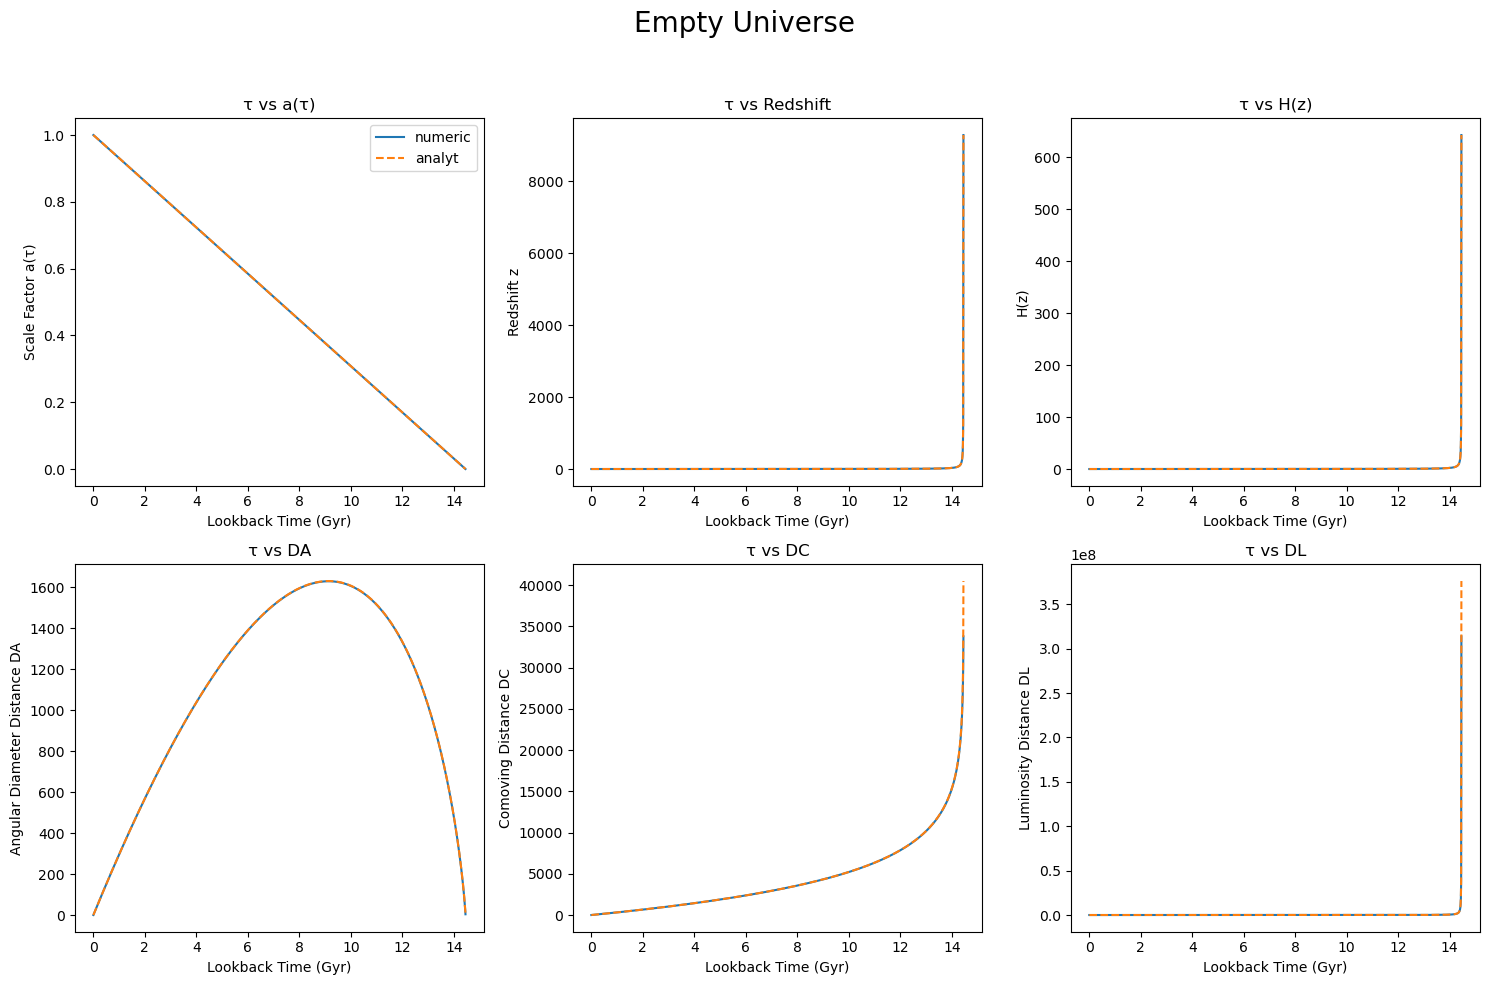

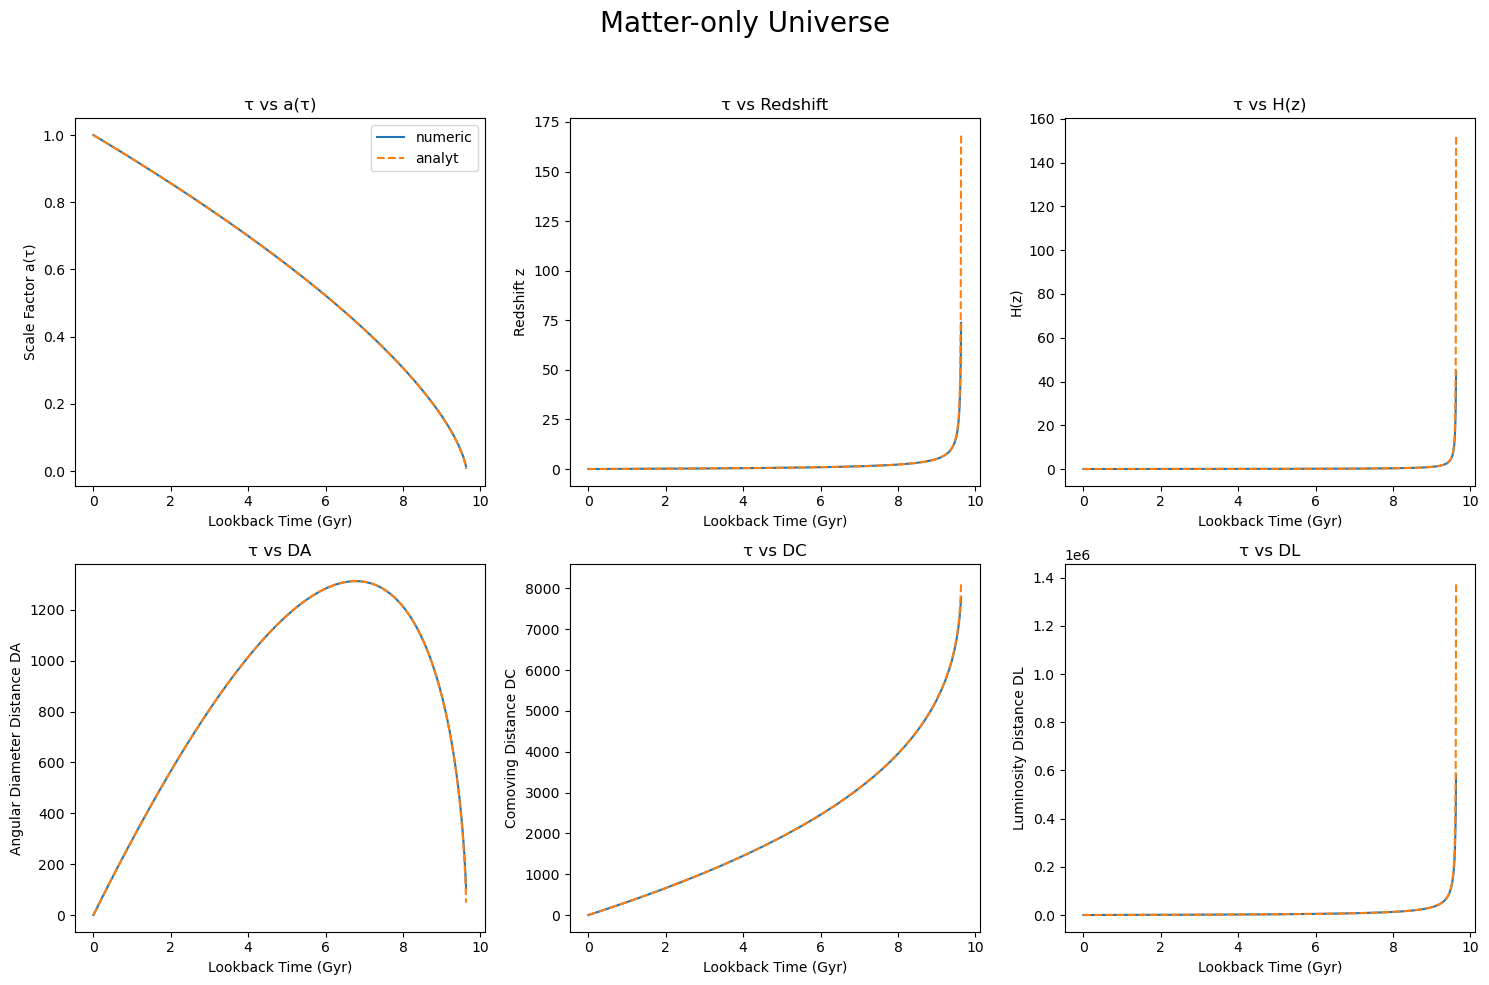

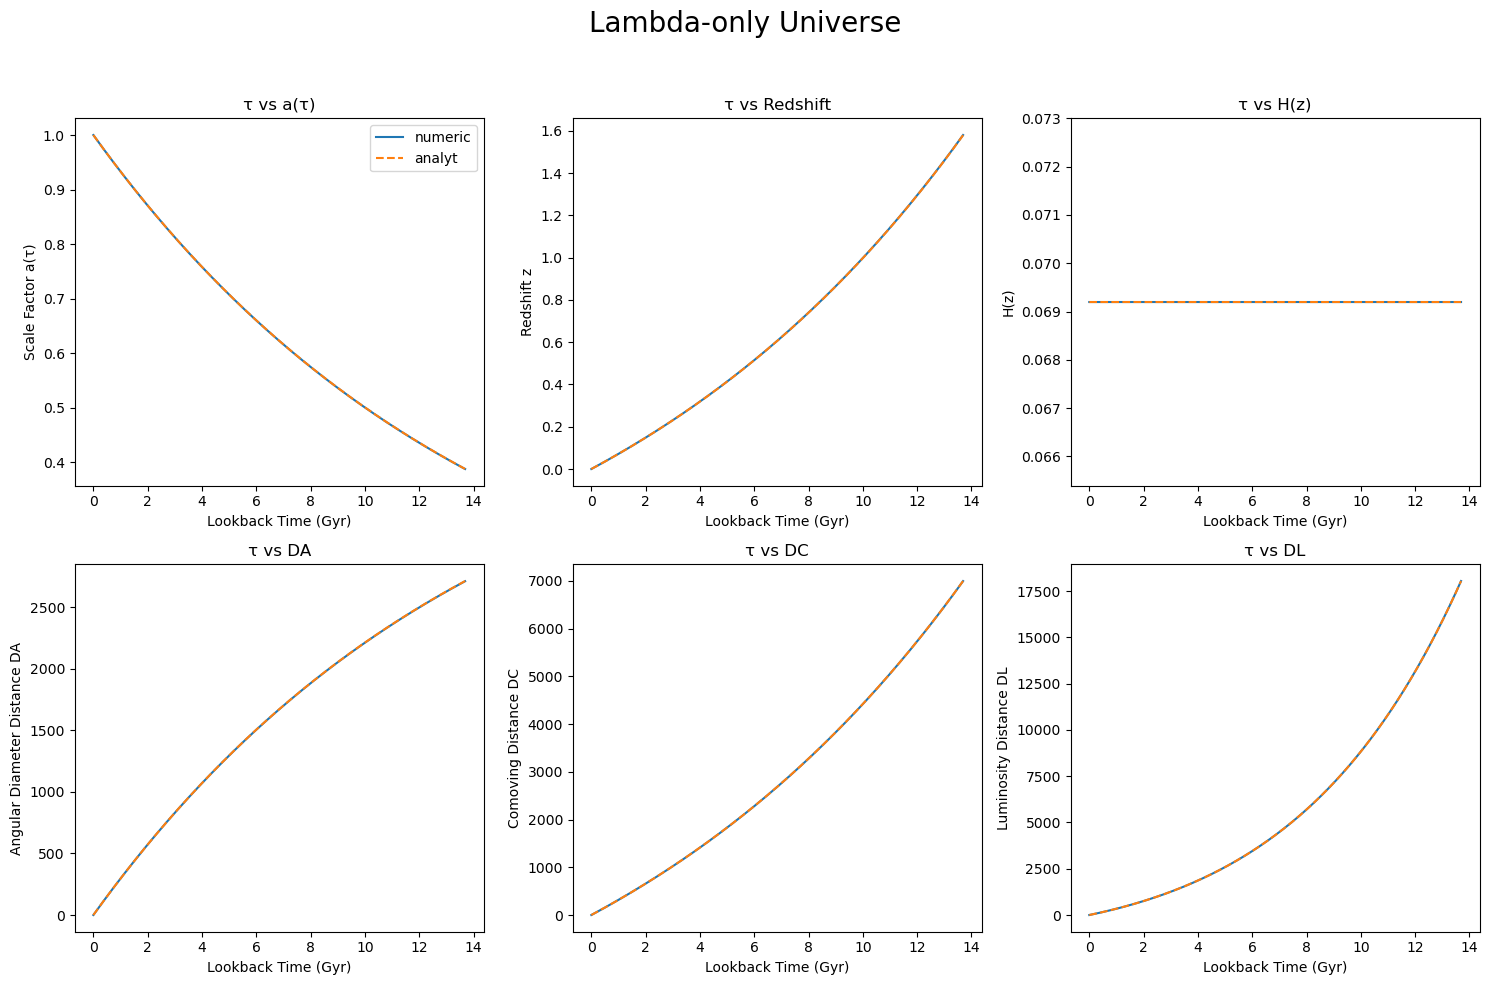

In [8]:
#plot for evaluating analytic and numeric value
type_universe_name=['Empty', 'Matter-only', 'Lambda-only']
for idx, i in enumerate(type_universe): 

    plt.figure(figsize=(15, 10))
    plt.suptitle(f'{type_universe_name[idx]} Universe', fontsize=20)

    plt.subplot(2, 3, 1)
    plt.plot(i.tau, i.a, label='numeric')
    plt.plot(i.tau, i.a_analyt, label='analyt', linestyle='--')
    plt.xlabel('Lookback Time (Gyr)')
    plt.ylabel('Scale Factor a(τ)')
    plt.legend()
    plt.title('τ vs a(τ)')

    plt.subplot(2, 3, 2)
    plt.plot(i.tau, i.redshift)
    plt.plot(i.tau, i.z_analyt, linestyle='--')
    plt.xlabel('Lookback Time (Gyr)')
    plt.ylabel('Redshift z')
    plt.title('τ vs Redshift')

    plt.subplot(2, 3, 3)
    plt.plot(i.tau, i.H)
    plt.plot(i.tau, i.H_analyt, linestyle='--')
    plt.xlabel('Lookback Time (Gyr)')
    plt.ylabel('H(z)')
    plt.title('τ vs H(z)')

    plt.subplot(2, 3, 4)
    plt.plot(i.tau, i.D_A_values)
    plt.plot(i.tau, i.DA_analyt, linestyle='--')
    plt.xlabel('Lookback Time (Gyr)')
    plt.ylabel('Angular Diameter Distance DA')
    plt.title('τ vs DA')

    plt.subplot(2, 3, 5)
    plt.plot(i.tau, i.D_C_values)
    plt.plot(i.tau, i.Dp_analyt, linestyle='--')
    plt.xlabel('Lookback Time (Gyr)')
    plt.ylabel('Comoving Distance DC')
    plt.title('τ vs DC')

    plt.subplot(2, 3, 6)
    plt.plot(i.tau, i.D_L_values)
    plt.plot(i.tau, i.DL_analyt, linestyle='--')
    plt.xlabel('Lookback Time (Gyr)')
    plt.ylabel('Luminosity Distance DL')
    plt.title('τ vs DL')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    #plt.legend()
    plt.show()



### Plotting Cosmological Parameters for Different Integration Steps

This section generates plots to compare cosmological parameters in our universe for three different integration steps ($\tau$): 0.01, 0.1, and 1. 

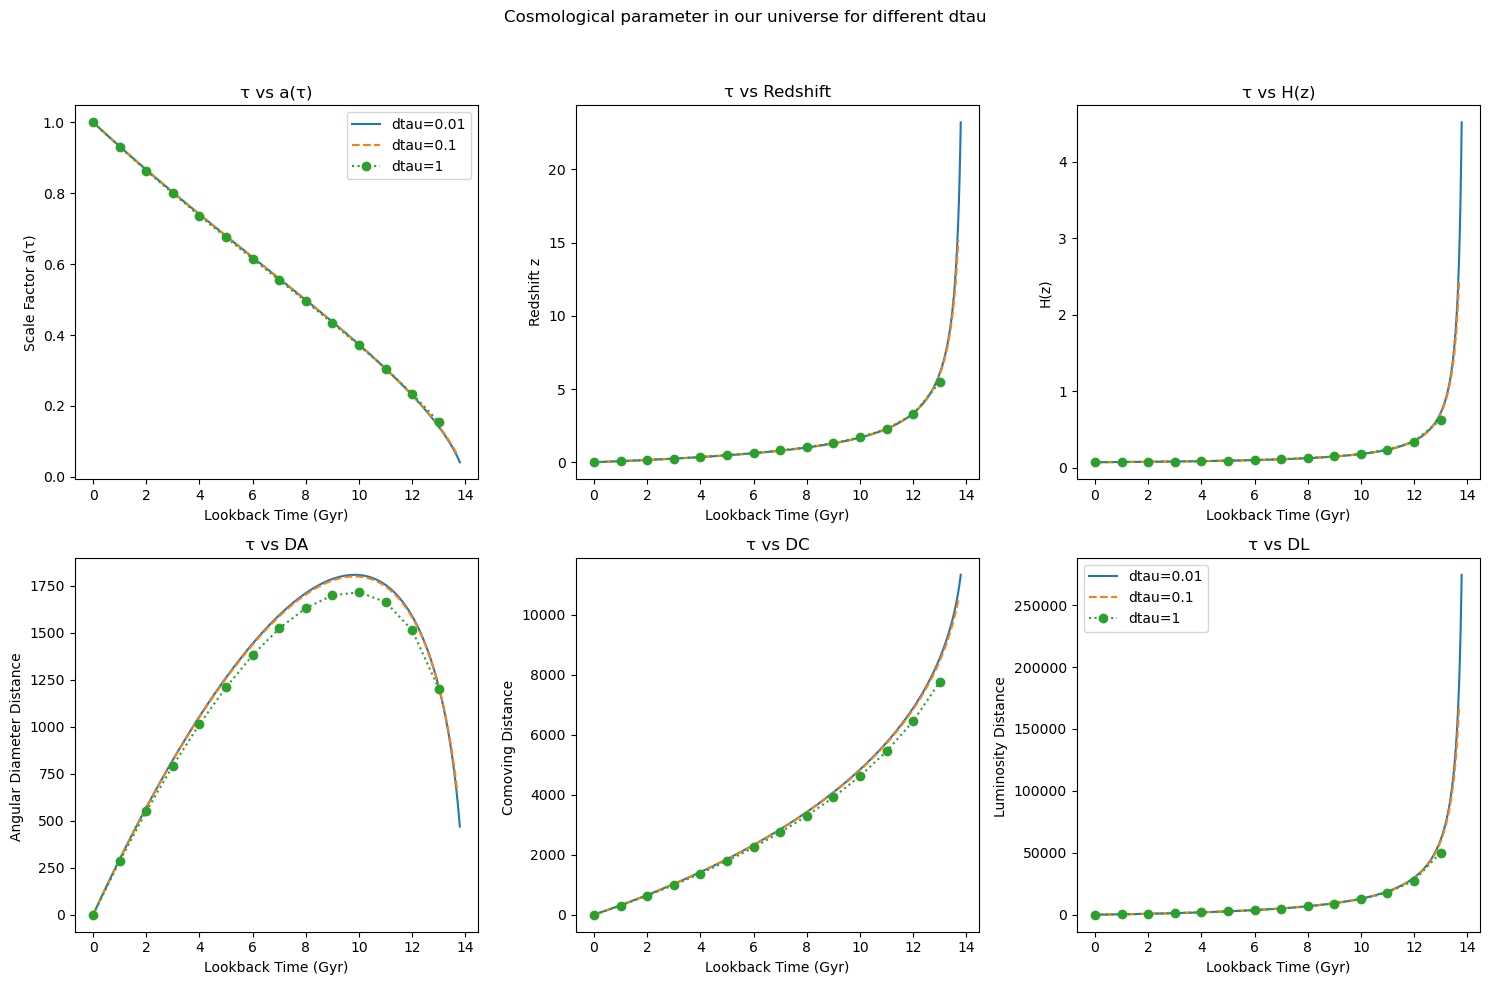

In [9]:
#plot for evaluating different tau

plt.figure(figsize=(15, 10))
plt.suptitle('Cosmological parameter in our universe for different dtau')

plt.subplot(2, 3, 1)
plt.plot(benchmark_d1.tau, benchmark_d1.a, label='dtau=0.01', linestyle= '-')
plt.plot(benchmark_d2.tau, benchmark_d2.a, label='dtau=0.1', linestyle='--')
plt.plot(benchmark_d3.tau, benchmark_d3.a, label='dtau=1', linestyle=':', marker='o')
plt.xlabel('Lookback Time (Gyr)')
plt.ylabel('Scale Factor a(τ)')
plt.legend()
plt.title('τ vs a(τ)')

plt.subplot(2, 3, 2)
plt.plot(benchmark_d1.tau, benchmark_d1.redshift, label='dtau=0.01')
plt.plot(benchmark_d2.tau, benchmark_d2.redshift, label='dtau=0.1', linestyle='--')
plt.plot(benchmark_d3.tau, benchmark_d3.redshift, label='dtau=1', linestyle=':', marker='o')
plt.xlabel('Lookback Time (Gyr)')
plt.ylabel('Redshift z')
plt.title('τ vs Redshift')

plt.subplot(2, 3, 3)
plt.plot(benchmark_d1.tau, benchmark_d1.H, label='dtau=0.01')
plt.plot(benchmark_d2.tau, benchmark_d2.H, label='dtau=0.1', linestyle='--')
plt.plot(benchmark_d3.tau, benchmark_d3.H, label='dtau=1', linestyle=':', marker='o')
plt.xlabel('Lookback Time (Gyr)')
plt.ylabel('H(z)')
plt.title('τ vs H(z)')

plt.subplot(2, 3, 4)
plt.plot(benchmark_d1.tau, benchmark_d1.D_A_values, label='dtau=0.01')
plt.plot(benchmark_d2.tau, benchmark_d2.D_A_values, label='dtau=0.1', linestyle='--')
plt.plot(benchmark_d3.tau, benchmark_d3.D_A_values, label='dtau=1', linestyle=':', marker='o')
plt.xlabel('Lookback Time (Gyr)')
plt.ylabel('Angular Diameter Distance ')
plt.title('τ vs DA')

plt.subplot(2, 3, 5)
plt.plot(benchmark_d1.tau, benchmark_d1.D_C_values, label='dtau=0.01')
plt.plot(benchmark_d2.tau, benchmark_d2.D_C_values, label='dtau=0.1', linestyle='--')
plt.plot(benchmark_d3.tau, benchmark_d3.D_C_values, label='dtau=1', linestyle=':', marker='o')
plt.xlabel('Lookback Time (Gyr)')
plt.ylabel('Comoving Distance ')
plt.title('τ vs DC')

plt.subplot(2, 3, 6)
plt.plot(benchmark_d1.tau, benchmark_d1.D_L_values, label='dtau=0.01')
plt.plot(benchmark_d2.tau, benchmark_d2.D_L_values, label='dtau=0.1', linestyle='--')
plt.plot(benchmark_d3.tau, benchmark_d3.D_L_values, label='dtau=1', linestyle=':', marker='o')
plt.xlabel('Lookback Time (Gyr)')
plt.ylabel('Luminosity Distance ')
plt.title('τ vs DL')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.legend()
plt.show()